## Analysis of EyeT4 Data for Empathy Prediction

In [9]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
import numpy as np

%matplotlib inline

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
data_dir = 'C:/Users/sayan/Desktop/contol'
dataset_ii_files = [filename_control for filename_control in os.listdir(data_dir) if 'dataset_II' in filename_control ]

dfs_control = []
for file_control in dataset_ii_files:
    df_contol = pd.read_csv(os.path.join(data_dir, file_control))
    dfs_control.append(df_contol)
dataset_ii_combined = pd.concat(dfs_control)

In [12]:
dataset_ii_combined

,Unnamed: 0,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,...,Original Media height,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Mouse position X,Mouse position Y
0,667,4394847,2575955327,NaN,Participant10,29.10.2020,Participant0010,Recording1,29.10.2020,29.10.2020,...,NaN,Unclassified,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
1,668,4394847,2575955327,NaN,Participant10,29.10.2020,Participant0010,Recording1,29.10.2020,29.10.2020,...,NaN,Unclassified,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2,669,4400762,2575961242,Eye Tracker,Participant10,29.10.2020,Participant0010,Recording1,29.10.2020,29.10.2020,...,416.0,Saccade,25.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
3,670,4409117,2575969597,Eye Tracker,Participant10,29.10.2020,Participant0010,Recording1,29.10.2020,29.10.2020,...,416.0,Saccade,25.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
4,671,4417439,2575977919,Eye Tracker,Participant10,29.10.2020,Participant0010,Recording1,29.10.2020,29.10.2020,...,416.0,Saccade,25.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7305,31731,65940337,1666203561855,NaN,Participant0060,20.09.2021,Participant0060,Recording4,20.09.2021,20.09.2021,...,NaN,Fixation,167.0,161.0,738.0,501.0,NaN,NaN,NaN,NaN
7306,31732,65945534,1666203567052,Eye Tracker,Participant0060,20.09.2021,Participant0060,Recording4,20.09.2021,20.09.2021,...,NaN,Fixation,167.0,161.0,738.0,501.0,NaN,NaN,NaN,NaN
7307,31733,65953860,1666203575378,Eye Tracker,Participant0060,20.09.2021,Participant0060,Recording4,20.09.2021,20.09.2021,...,NaN,Fixation,167.0,161.0,738.0,501.0,NaN,NaN,NaN,NaN
7308,31734,65962157,1666203583675,Eye Tracker,Participant0060,20.09.2021,Participant0060,Recording4,20.09.2021,20.09.2021,...,NaN,Fixation,167.0,161.0,738.0,501.0,NaN,NaN,NaN,NaN


In [20]:
participant_counts_control = dataset_ii_combined.groupby('Participant name')['Recording start time UTC'].nunique()

In [21]:
participant_counts_control

Participant name
Participant0002    4
Participant0004    4
Participant0006    4
Participant0008    4
Participant0010    4
Participant0012    4
Participant0014    4
Participant0016    4
Participant0018    4
Participant0020    4
Participant0022    4
Participant0024    4
Participant0028    4
Participant0030    4
Participant0034    4
Participant0036    4
Participant0038    4
Participant0040    4
Participant0042    4
Participant0044    4
Participant0046    4
Participant0048    4
Participant0050    4
Participant0052    4
Participant0054    4
Participant0056    4
Participant0058    4
Participant0060    4
Name: Recording start time UTC, dtype: int64

In [19]:
###Keeping only the participant who gave 4 trials

dataset_ii_combined =dataset_ii_combined[(dataset_ii_combined['Participant name'] != 'Participant0026') & 
                           (dataset_ii_combined['Participant name'] != 'Participant0032')]

In [22]:
#Keeping only 3 classes for the eye movement type. Replacing the EyesNotFound as Unclassified
dataset_ii_combined = dataset_ii_combined.replace("EyesNotFound", "Unclassified")
dataset_ii_combined['Eye movement type'].fillna("Unclassified", inplace=True)

In [23]:
dataset_ii_combined['Eye movement type'].value_counts()

Fixation        586683
Unclassified    276848
Saccade         159639
Name: Eye movement type, dtype: int64

In [29]:
control_df = dataset_ii_combined[["Participant name", "Recording timestamp", "Eye movement type", "Event", "Pupil diameter left",
                                     "Pupil diameter right"]]

In [30]:
#Converting the Pupil diameter left and right to float

control_df["Pupil diameter left"] = control_df["Pupil diameter left"].str.replace(',', '.').astype(float)
control_df["Pupil diameter right"] = control_df["Pupil diameter right"].str.replace(',', '.').astype(float)

In [31]:
#Function to fill the left pupil diameneter based on right
def fill_left_based_on_right(left, right):
    if np.isnan(left) and ~np.isnan(right): return right
    return left

In [32]:
#Function to fill the rigth pupil diameneter based on left 

def fill_right_based_on_left(left, right):
    if np.isnan(right) and ~np.isnan(left): return left
    return right

In [33]:
control_df["Pupil diameter left"] = control_df.apply(lambda x: fill_left_based_on_right(x['Pupil diameter left'],
                                                                                                   x['Pupil diameter right']), axis = 1 )
control_df["Pupil diameter right"] = control_df.apply(lambda x: fill_right_based_on_left(x['Pupil diameter left'],
                                                                                                    x['Pupil diameter right']), axis = 1)

In [34]:
control_df["Pupil diameter left"]

0        NaN
1        NaN
2        NaN
3        NaN
4       3.93
        ... 
7305     NaN
7306     NaN
7307    3.27
7308     NaN
7309     NaN
Name: Pupil diameter left, Length: 1023170, dtype: float64

In [35]:
control_df["Pupil_diameter_mean"] = (control_df['Pupil diameter left'] + control_df['Pupil diameter right'])/2

In [36]:
control_df["Pupil_diameter_mean"]

0        NaN
1        NaN
2        NaN
3        NaN
4       3.93
        ... 
7305     NaN
7306     NaN
7307    3.22
7308     NaN
7309     NaN
Name: Pupil_diameter_mean, Length: 1023170, dtype: float64

In [37]:
control_df

,Participant name,Recording timestamp,Eye movement type,Event,Pupil diameter left,Pupil diameter right,Pupil_diameter_mean
0,Participant0010,4394847,Unclassified,Eye tracker Calibration end,NaN,NaN,NaN
1,Participant0010,4394847,Unclassified,ImageStimulusStart,NaN,NaN,NaN
2,Participant0010,4400762,Saccade,NaN,NaN,NaN,NaN
3,Participant0010,4409117,Saccade,NaN,NaN,NaN,NaN
4,Participant0010,4417439,Saccade,NaN,3.93,3.93,3.93
...,...,...,...,...,...,...,...
7305,Participant0060,65940337,Fixation,ImageStimulusEnd,NaN,NaN,NaN
7306,Participant0060,65945534,Fixation,NaN,NaN,NaN,NaN
7307,Participant0060,65953860,Fixation,NaN,3.27,3.17,3.22
7308,Participant0060,65962157,Fixation,NaN,NaN,NaN,NaN


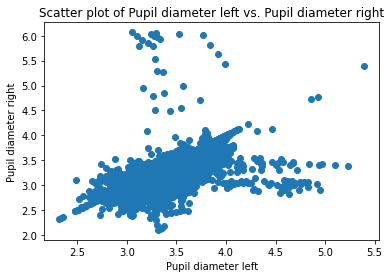

In [38]:
#Scatter plot to plot the Pupil Diameter left vs Pupil Diameter right for participant 10

participant_data = control_df[control_df['Participant name'] == 'Participant0010']
participant_data['Pupil diameter left'] = participant_data['Pupil diameter left'].interpolate()
participant_data['Pupil diameter right'] = participant_data['Pupil diameter right'].interpolate()

# Create a scatter plot of the 'Pupil diameter left' and 'Pupil diameter right' columns for all participants
plt.scatter(participant_data['Pupil diameter left'], participant_data['Pupil diameter right'])
plt.xlabel('Pupil diameter left')
plt.ylabel('Pupil diameter right')
plt.title('Scatter plot of Pupil diameter left vs. Pupil diameter right')
plt.show()

<Figure size 720x576 with 0 Axes>

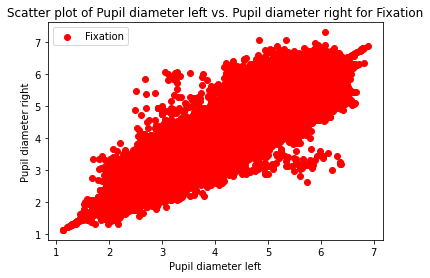

<Figure size 720x576 with 0 Axes>

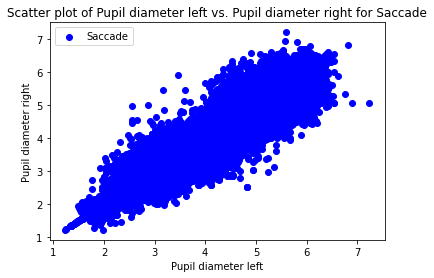

<Figure size 720x576 with 0 Axes>

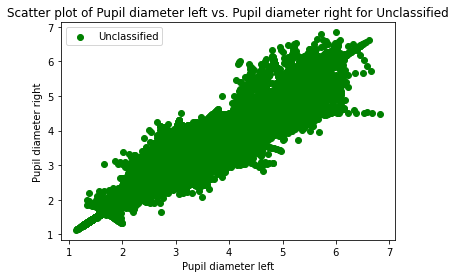

In [39]:
# Group the data by 'Eye movement type'
grouped_data = control_df.groupby('Eye movement type')

# Define a color map for each eye movement type
colors = {'Fixation': 'red', 'Saccade': 'blue', 'Unclassified': 'green'}

# Create a scatter plot of the 'Pupil diameter left' and 'Pupil diameter right' columns for each eye movement type
for key, group in grouped_data:
    plt.figure(figsize = (10,8))
    fig, ax = plt.subplots()
    participant_data = group
    participant_data['Pupil diameter left'] = participant_data['Pupil diameter left'].interpolate()
    participant_data['Pupil diameter right'] = participant_data['Pupil diameter right'].interpolate()
    ax.scatter(participant_data['Pupil diameter left'], participant_data['Pupil diameter right'], c=colors[key], label=key)
    ax.set_xlabel('Pupil diameter left')
    ax.set_ylabel('Pupil diameter right')
    ax.set_title('Scatter plot of Pupil diameter left vs. Pupil diameter right for {}'.format(key))
    ax.legend()
    plt.show()

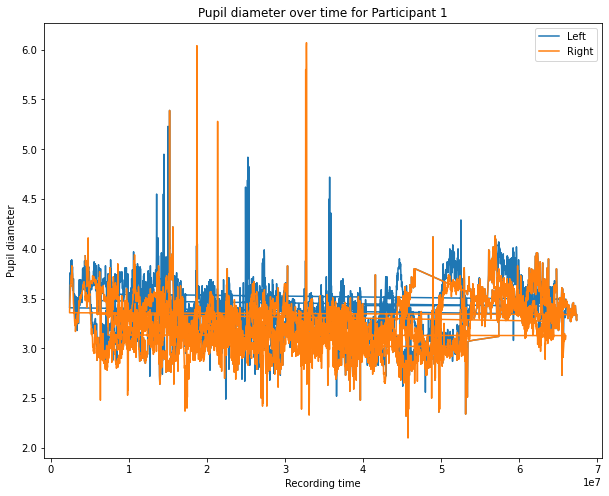

In [42]:
#Pupil diameter over timestamp for participant 10

participant_data = control_df[control_df['Participant name'] == 'Participant0010']

# Fill missing values using linear interpolation
participant_data['Pupil diameter left'] = participant_data['Pupil diameter left'].interpolate()
participant_data['Pupil diameter right'] = participant_data['Pupil diameter right'].interpolate()

# Creating a line plot of the 'Pupil diameter left' and 'Pupil diameter right' columns over time
plt.figure(figsize = (10,8))
plt.plot(participant_data['Recording timestamp'], participant_data['Pupil diameter left'], label='Left')
plt.plot(participant_data['Recording timestamp'], participant_data['Pupil diameter right'], label='Right')
plt.xlabel('Recording time')
plt.ylabel('Pupil diameter')
plt.title('Pupil diameter over time for Participant 1')
plt.legend()
plt.show()

### Creating time series for participant( 1 time series each trial)

In [47]:
control_results = pd.DataFrame(columns=['Participant', 'Time Series', 'Mean Pupil Diameter', 
                                        'Fixation Fraction', 'Saccade Fraction', 'Fixation Count', 'Saccade Count', 'Fixation Duration', 'Saccade Duration'])

# Group the eye movement data by participant
grouped_data = control_df.groupby('Participant name')

# Loop over each participant and extract data for each time series
for name, group in grouped_data:

    # Finding the start and end timestamps for the image stimulus presentation 
    start_timestamp = group.loc[group['Event'] == 'ImageStimulusStart', 'Recording timestamp'].values[0]
    end_timestamp = group.loc[group['Event'] == 'ImageStimulusEnd', 'Recording timestamp'].values[0]

    # Calculating the total duration of the image stimulus presentation
    total_duration = end_timestamp - start_timestamp

    # Calculate the duration of each time series
    series_duration = total_duration / 4

    # Loop over each time series and extract the eye movement data
    for i in range(4):
        # Calculate the start and end timestamps for this time series
        series_start = start_timestamp + i * series_duration
        series_end = start_timestamp + (i+1) * series_duration

        # Filter the eye movement data for this time series
        series_data = group[(group['Recording timestamp'] >= series_start) & (group['Recording timestamp'] < series_end)]

        # Calculate the mean pupil diameter for this time series
        mean_pupil_diameter = series_data['Pupil_diameter_mean'].mean()
        mean_pupil_diameter_left = series_data['Pupil diameter left'].mean()
        mean_pupil_diameter_right = series_data['Pupil diameter right'].mean()

        # Calculate the fixation and saccade fractions for this time series
        total_events = len(series_data)
        fixation_events = len(series_data[series_data['Eye movement type'] == 'Fixation'])
        saccade_events = len(series_data[series_data['Eye movement type'] == 'Saccade'])

        fixation_frac = fixation_events / total_events
        saccade_frac = saccade_events / total_events

        # Calculate the fixation and saccade durations for this time series
        fixation_duration = series_data[series_data['Eye movement type'] == 'Fixation']['Recording timestamp'].diff().sum()
        saccade_duration = series_data[series_data['Eye movement type'] == 'Saccade']['Recording timestamp'].diff().sum()

        # Append the results for this time series as a new row to the DataFrame
        control_results = control_results.append({'Participant': name, 'Time Series': i+1,
                                  'Mean Pupil Diameter left': mean_pupil_diameter_left,
                                  'Mean Pupil Diameter right': mean_pupil_diameter_right,
                                  'Mean Pupil Diameter': mean_pupil_diameter, 
                                  'Fixation Fraction': fixation_frac,
                                  'Saccade Fraction': saccade_frac,
                                  'Fixation Count': fixation_events, 'Saccade Count': saccade_events, 
                                  'Fixation Duration': fixation_duration, 'Saccade Duration': saccade_duration}, 
                                 ignore_index=True)

In [49]:
control_results

,Participant,Time Series,Mean Pupil Diameter,Fixation Fraction,Saccade Fraction,Fixation Count,Saccade Count,Fixation Duration,Saccade Duration,Mean Pupil Diameter left,Mean Pupil Diameter right
0,Participant0002,1,2.907293,0.645858,0.199880,8608,2664,13441927.0,13479925.0,2.933216,2.881371
1,Participant0002,2,2.974948,0.667367,0.218253,8892,2908,13616948.0,13333666.0,2.996414,2.953482
2,Participant0002,3,3.079200,0.396821,0.276062,5192,3612,13125405.0,13608674.0,3.035947,3.122453
3,Participant0002,4,3.011930,0.633228,0.227652,8812,3168,13399117.0,13482410.0,2.999803,3.024056
4,Participant0004,1,3.067076,0.341935,0.254032,6360,4725,12282141.0,12782191.0,3.079353,3.054798
...,...,...,...,...,...,...,...,...,...,...,...
107,Participant0058,4,4.000215,0.741183,0.117461,5149,816,14490864.0,14449266.0,4.030880,3.969551
108,Participant0060,1,3.216202,0.690699,0.139516,5020,1014,14574536.0,14346469.0,3.280834,3.151569
109,Participant0060,2,3.253124,0.696111,0.124028,5012,893,14987313.0,14804004.0,3.314231,3.192017
110,Participant0060,3,3.209456,0.741008,0.129982,5336,936,14987150.0,14928851.0,3.259646,3.159266


In [50]:
control_results.to_csv('Control_group.csv') ##saving the table in a csv file

In [51]:
control_results['Participant'] = control_results['Participant'].apply(lambda z:z.replace("Participant000", ""))
control_results['Participant'] = control_results['Participant'].apply(lambda z:z.replace("Participant00", ""))

### Plotting mean pupil diameter left and right  for each participant

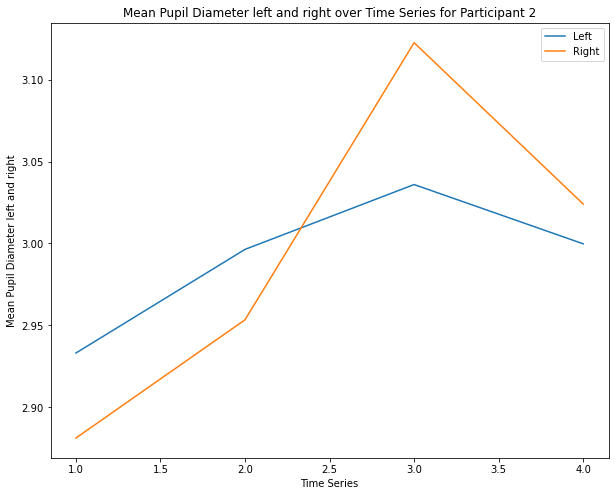

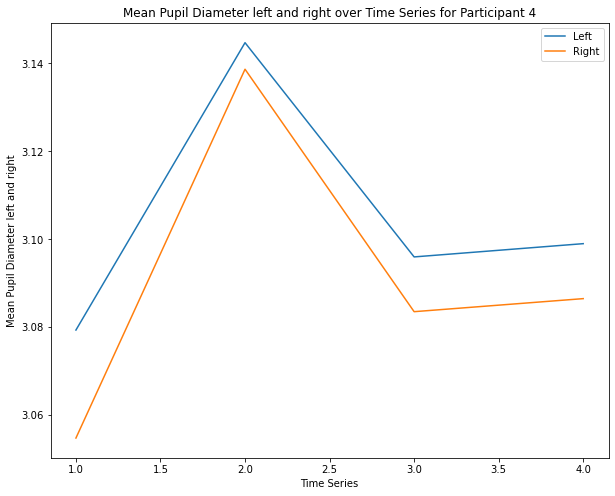

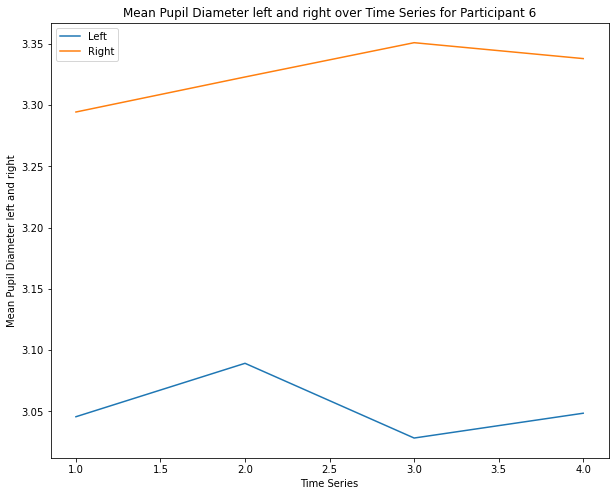

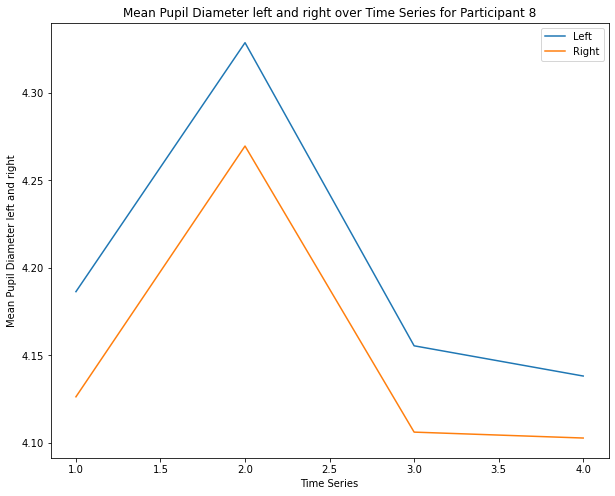

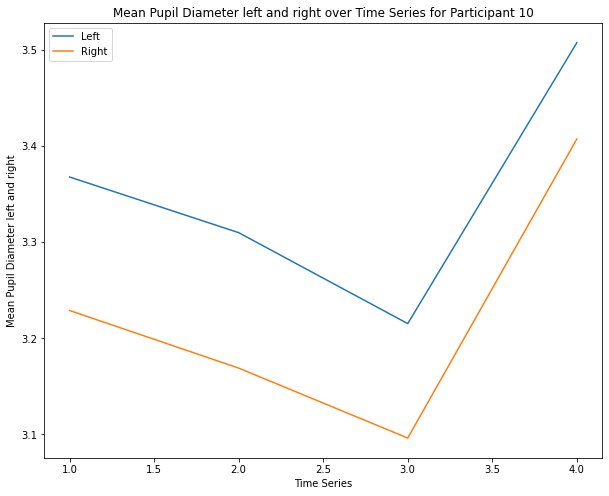

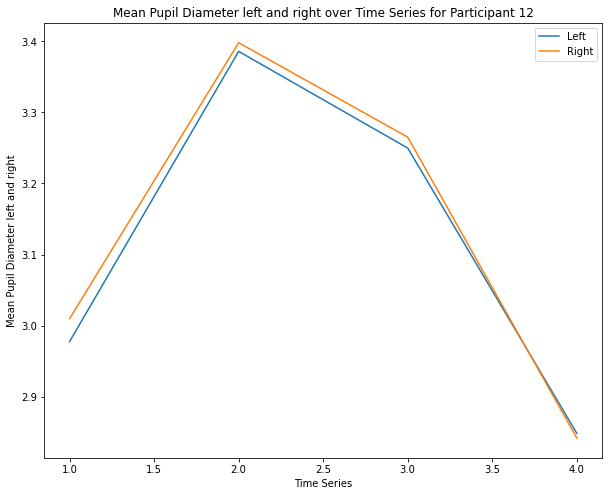

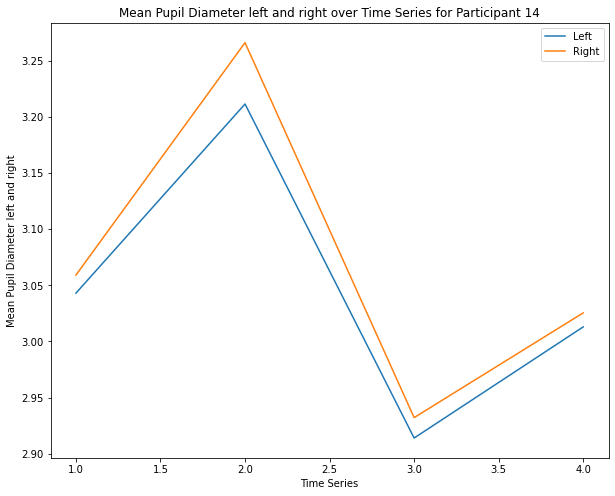

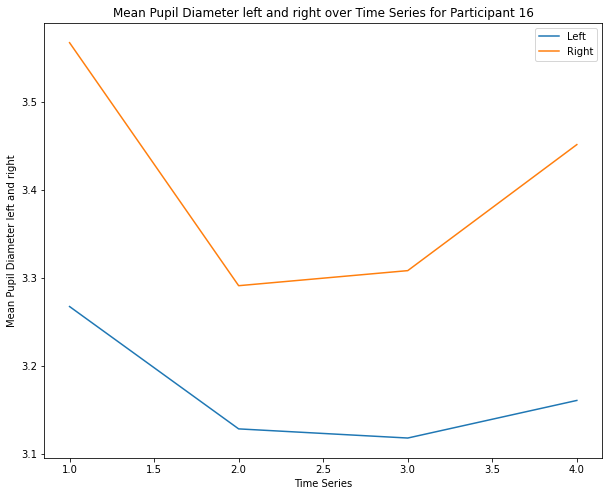

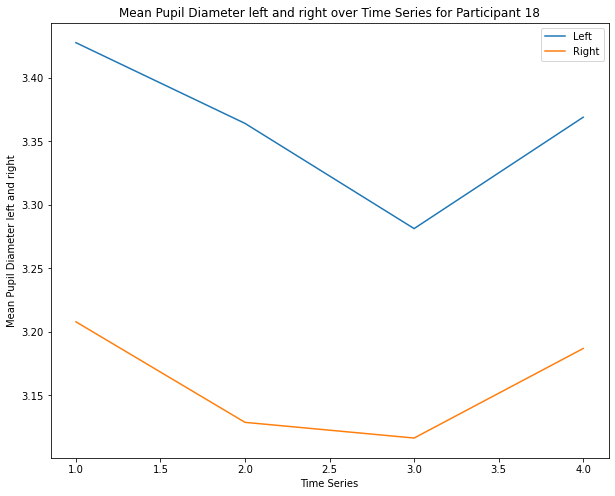

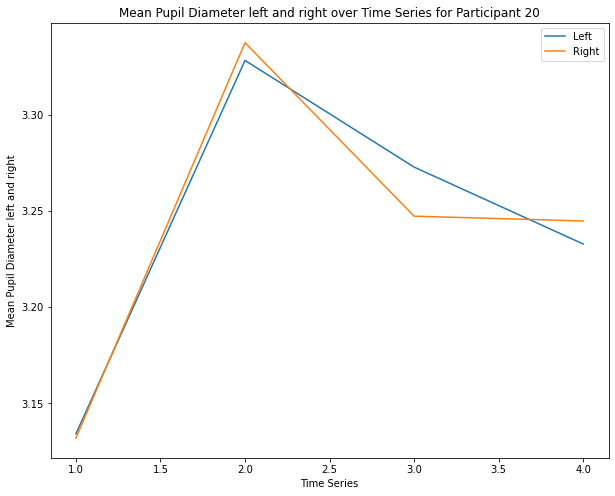

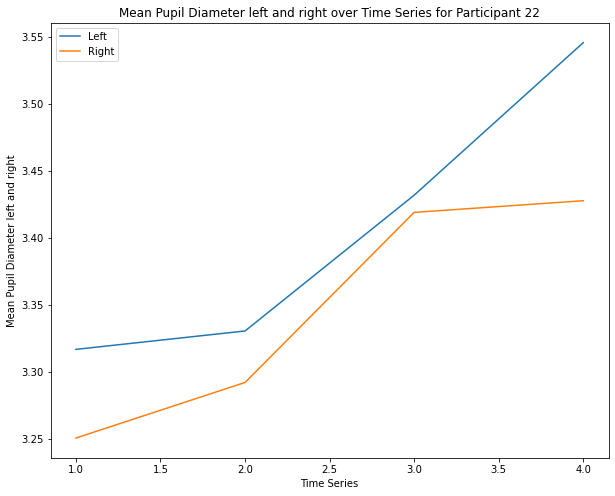

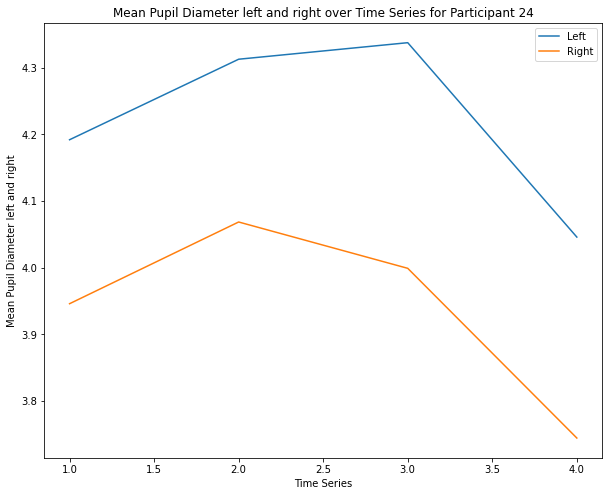

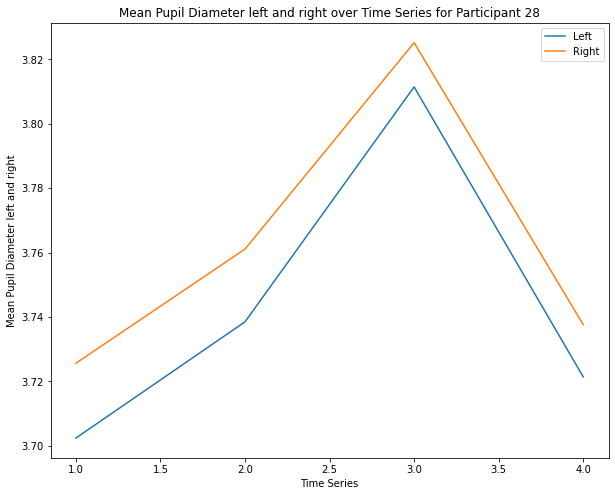

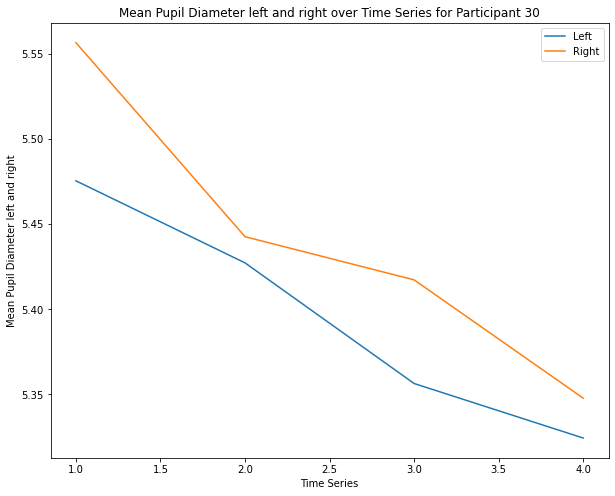

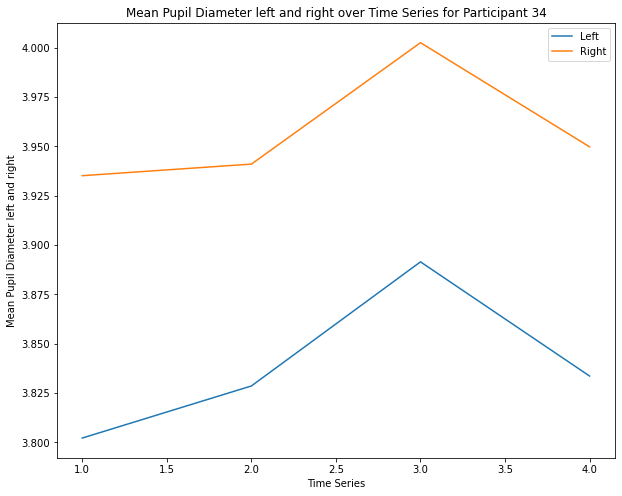

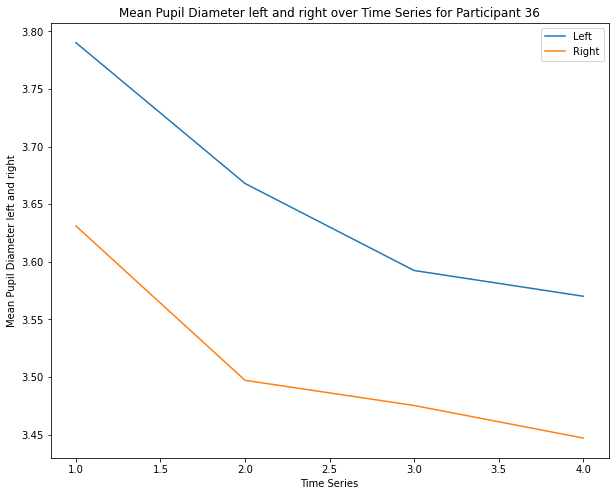

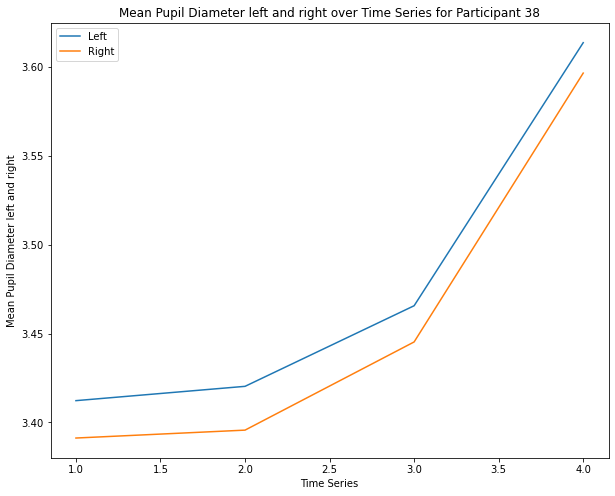

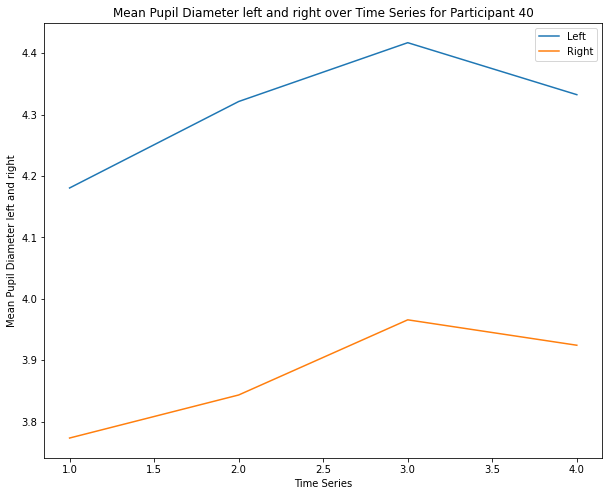

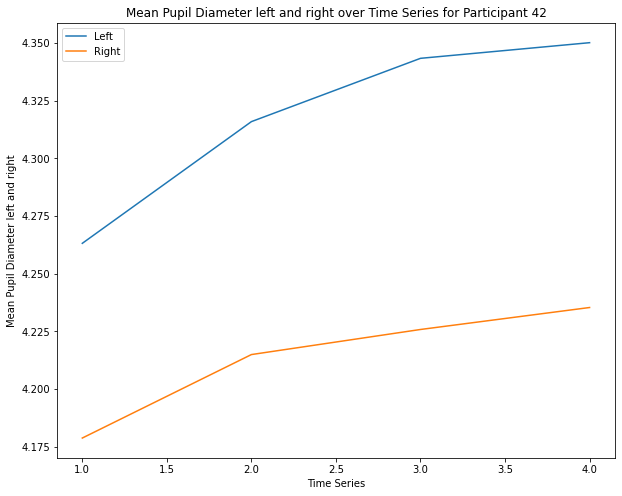

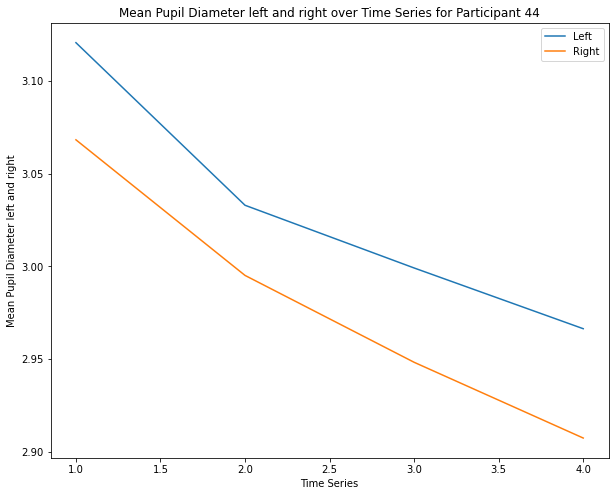

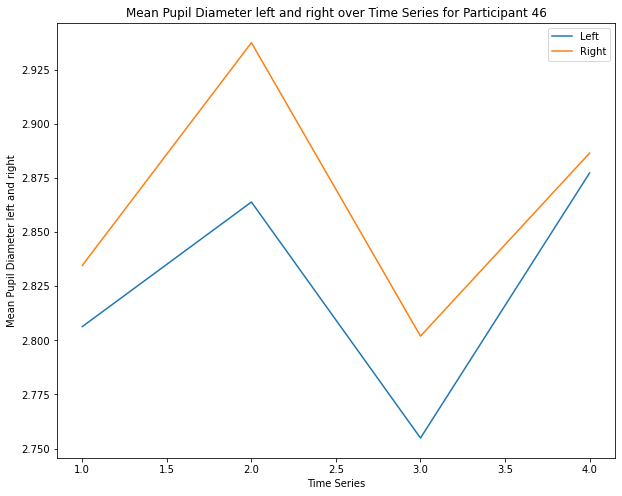

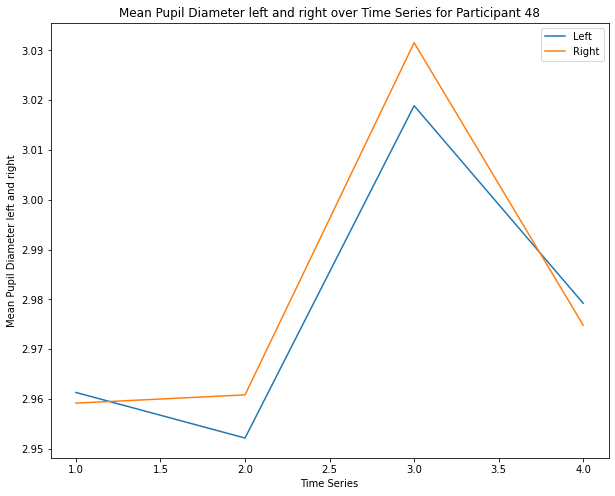

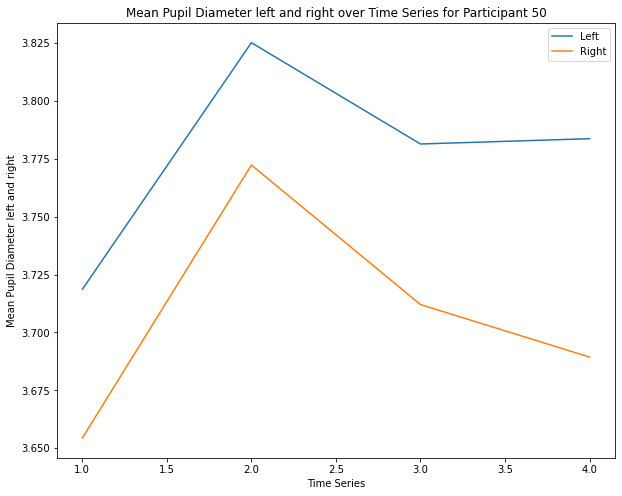

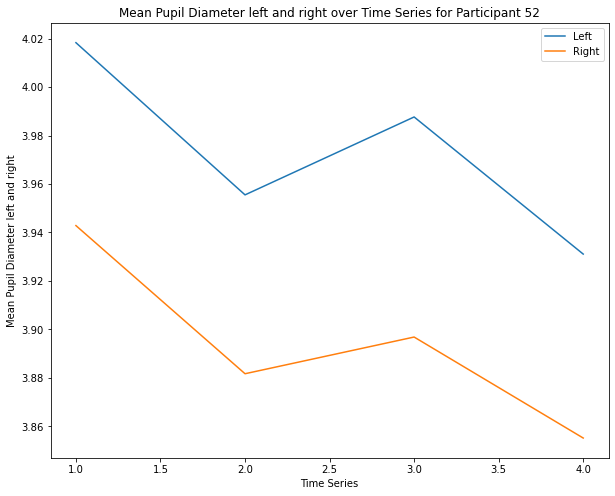

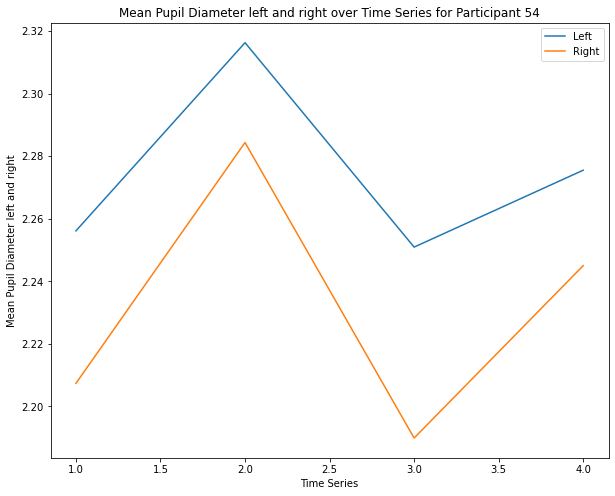

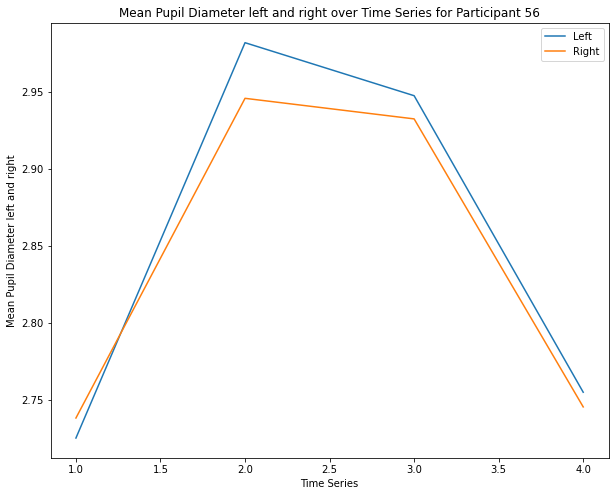

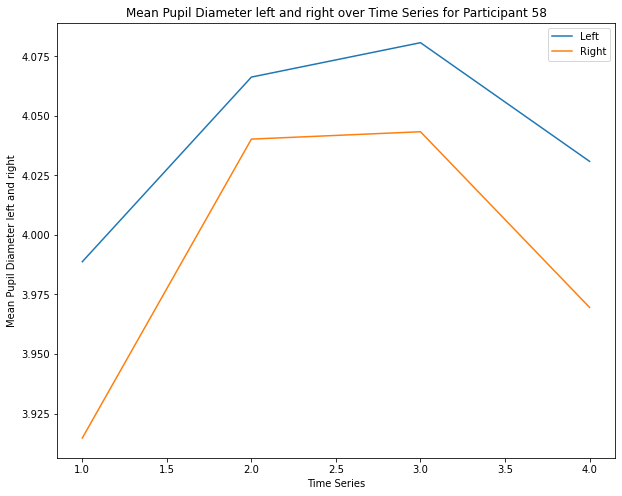

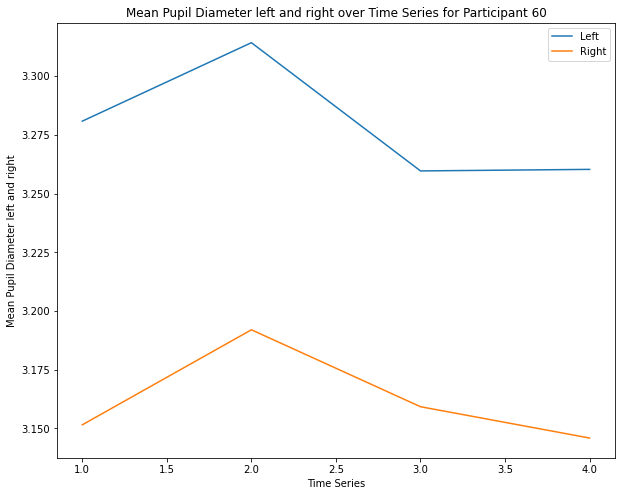

In [53]:
participants = control_results['Participant'].unique()


for participant_name in participants:
    fig, ax = plt.subplots(figsize=(10, 8))
    participant_data = control_results[control_results['Participant'] == participant_name]
    #ax.plot(participant_data['Time Series'], participant_data['Mean Pupil Diameter'])
    ax.plot(participant_data['Time Series'], participant_data['Mean Pupil Diameter left'], label='Left')
    ax.plot(participant_data['Time Series'], participant_data['Mean Pupil Diameter right'], label='Right')
    ax.set_xlabel('Time Series')
    ax.set_ylabel('Mean Pupil Diameter left and right')
    ax.set_title('Mean Pupil Diameter left and right over Time Series for Participant {}'.format(participant_name))
    ax.legend()
    plt.show()

### Extracting the emapthy score before and after the intervention

In [55]:

columns_A = ['Participant nr','Total Score original','Total Score extended']

empathy_before = pd.read_csv('Questionnaire_datasetIA.csv',encoding = 'ISO-8859-1',
                             usecols=columns_A, dtype={'Participant nr' : str})

empathy_after = pd.read_csv('Questionnaire_datasetIB.csv',encoding = 'ISO-8859-1',
                             usecols=columns_A, dtype={'Participant nr' : str})

In [56]:
empathy_before

,Participant nr,Total Score extended,Total Score original
0,1,134,108
1,2,133,105
2,3,116,81
3,4,114,96
4,5,138,106
5,6,121,92
6,7,127,81
7,8,116,86
8,9,114,87
9,10,117,82


### Merging the empathy scores with the eye tracking data

In [58]:
merged_before = pd.merge(control_results, empathy_before[['Participant nr', 'Total Score extended']], left_on='Participant',
                         right_on='Participant nr', how='left')


merged_before = merged_before.rename(columns={'Total Score extended': 'Total Score extended before'})

merged_before = merged_before.drop('Participant nr', axis=1)

merged_after = pd.merge(control_results, empathy_after[['Participant nr', 'Total Score extended']], left_on='Participant', right_on='Participant nr', how='left')


merged_after = merged_after.rename(columns={'Total Score extended': 'Total Score extended after'})


merged_after = merged_after.drop('Participant nr', axis=1)


merged_data  = pd.concat([merged_before, merged_after[['Total Score extended after']]], axis=1)


In [59]:
merged_data

,Participant,Time Series,Mean Pupil Diameter,Fixation Fraction,Saccade Fraction,Fixation Count,Saccade Count,Fixation Duration,Saccade Duration,Mean Pupil Diameter left,Mean Pupil Diameter right,Total Score extended before,Total Score extended after
0,2,1,2.907293,0.645858,0.199880,8608,2664,13441927.0,13479925.0,2.933216,2.881371,133,127
1,2,2,2.974948,0.667367,0.218253,8892,2908,13616948.0,13333666.0,2.996414,2.953482,133,127
2,2,3,3.079200,0.396821,0.276062,5192,3612,13125405.0,13608674.0,3.035947,3.122453,133,127
3,2,4,3.011930,0.633228,0.227652,8812,3168,13399117.0,13482410.0,2.999803,3.024056,133,127
4,4,1,3.067076,0.341935,0.254032,6360,4725,12282141.0,12782191.0,3.079353,3.054798,114,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,58,4,4.000215,0.741183,0.117461,5149,816,14490864.0,14449266.0,4.030880,3.969551,131,72
108,60,1,3.216202,0.690699,0.139516,5020,1014,14574536.0,14346469.0,3.280834,3.151569,123,80
109,60,2,3.253124,0.696111,0.124028,5012,893,14987313.0,14804004.0,3.314231,3.192017,123,80
110,60,3,3.209456,0.741008,0.129982,5336,936,14987150.0,14928851.0,3.259646,3.159266,123,80


In [60]:
merged_data['Avg_Empathy_Score'] = (merged_data['Total Score extended before'] + merged_data['Total Score extended after'])/2
merged_data['Emapthy_Score_diff'] =   merged_data['Total Score extended after']  - merged_data['Total Score extended before']

In [61]:
merged_data

,Participant,Time Series,Mean Pupil Diameter,Fixation Fraction,Saccade Fraction,Fixation Count,Saccade Count,Fixation Duration,Saccade Duration,Mean Pupil Diameter left,Mean Pupil Diameter right,Total Score extended before,Total Score extended after,Avg_Empathy_Score,Emapthy_Score_diff
0,2,1,2.907293,0.645858,0.199880,8608,2664,13441927.0,13479925.0,2.933216,2.881371,133,127,130.0,-6
1,2,2,2.974948,0.667367,0.218253,8892,2908,13616948.0,13333666.0,2.996414,2.953482,133,127,130.0,-6
2,2,3,3.079200,0.396821,0.276062,5192,3612,13125405.0,13608674.0,3.035947,3.122453,133,127,130.0,-6
3,2,4,3.011930,0.633228,0.227652,8812,3168,13399117.0,13482410.0,2.999803,3.024056,133,127,130.0,-6
4,4,1,3.067076,0.341935,0.254032,6360,4725,12282141.0,12782191.0,3.079353,3.054798,114,120,117.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,58,4,4.000215,0.741183,0.117461,5149,816,14490864.0,14449266.0,4.030880,3.969551,131,72,101.5,-59
108,60,1,3.216202,0.690699,0.139516,5020,1014,14574536.0,14346469.0,3.280834,3.151569,123,80,101.5,-43
109,60,2,3.253124,0.696111,0.124028,5012,893,14987313.0,14804004.0,3.314231,3.192017,123,80,101.5,-43
110,60,3,3.209456,0.741008,0.129982,5336,936,14987150.0,14928851.0,3.259646,3.159266,123,80,101.5,-43


###  Plot the changes in mean pupil diameter for all participants over time series

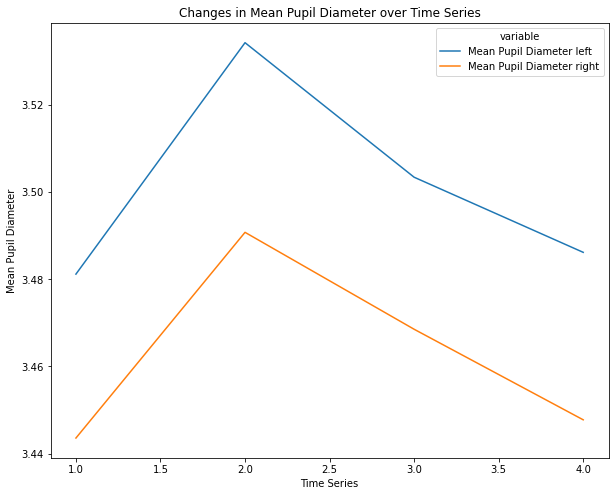

In [62]:
# Melt the data to create a long-form DataFrame
melted_data = pd.melt(merged_data, id_vars=['Participant', 'Time Series'], value_vars=['Mean Pupil Diameter left', 'Mean Pupil Diameter right'])


plt.figure(figsize = (10,8))
sns.lineplot(x='Time Series', y='value', hue='variable', data=melted_data, ci=None)

plt.title('Changes in Mean Pupil Diameter over Time Series')
plt.xlabel('Time Series')
plt.ylabel('Mean Pupil Diameter')
plt.show()

### Mean Pupil Diameter over time series for each participant

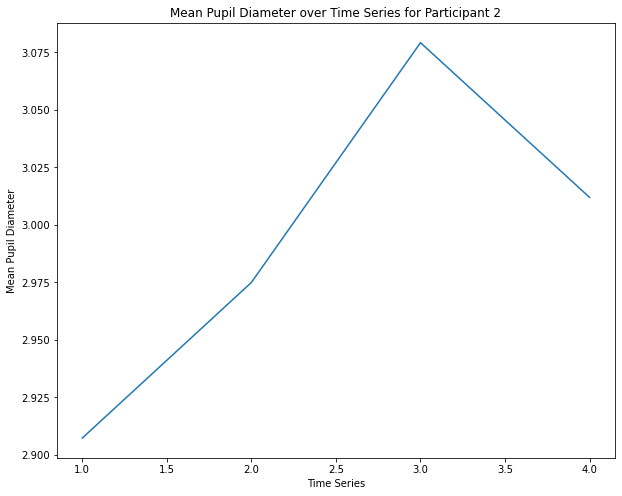

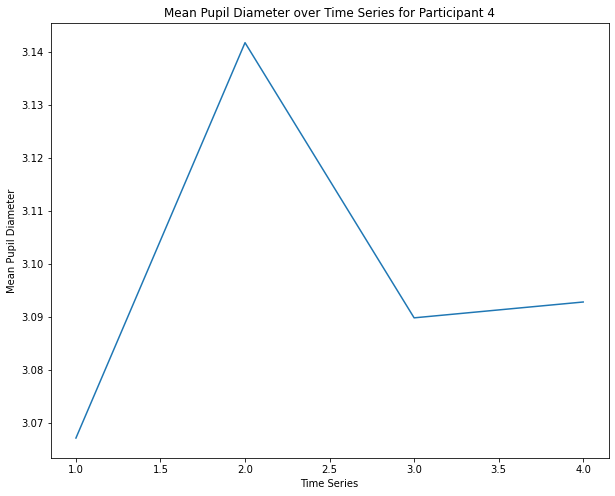

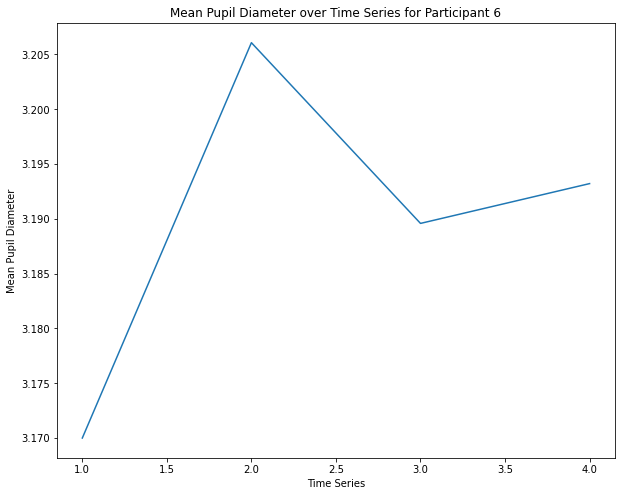

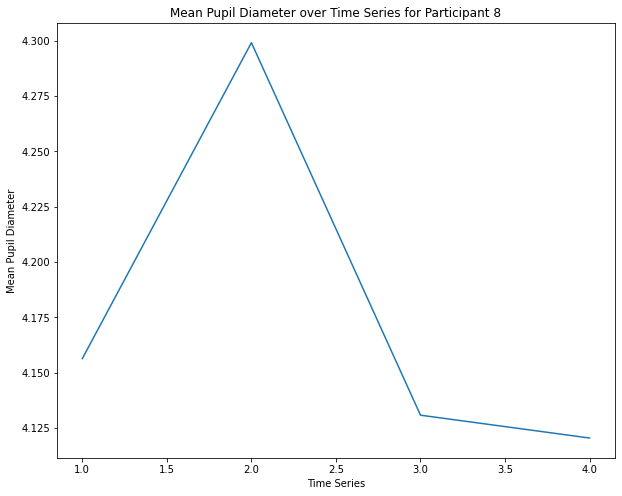

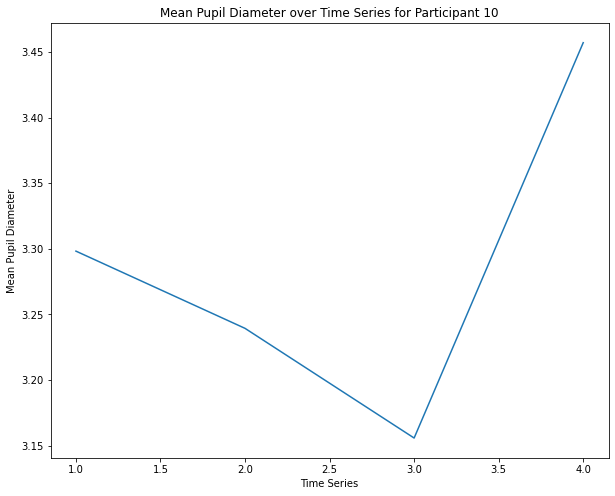

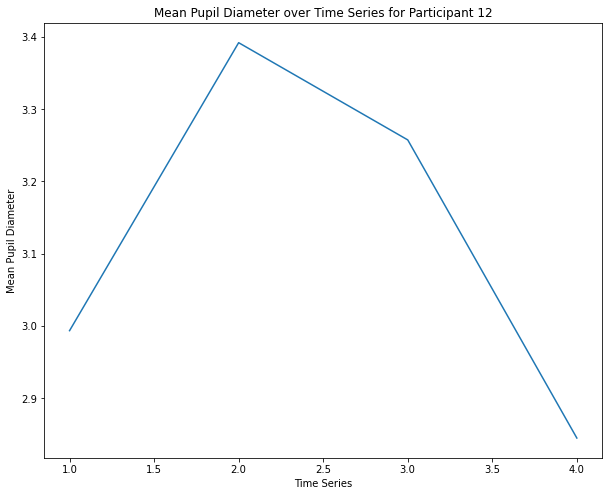

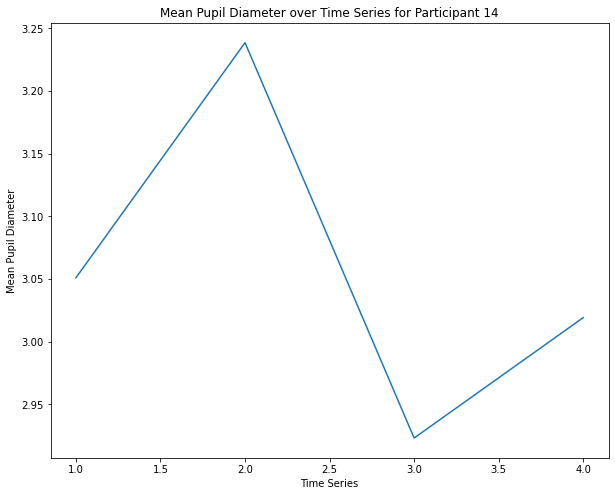

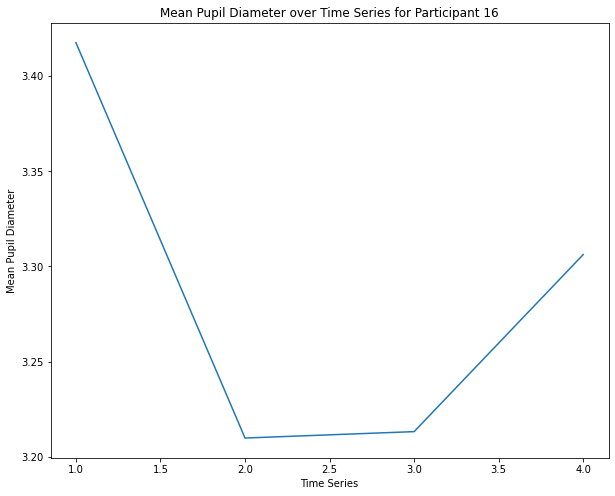

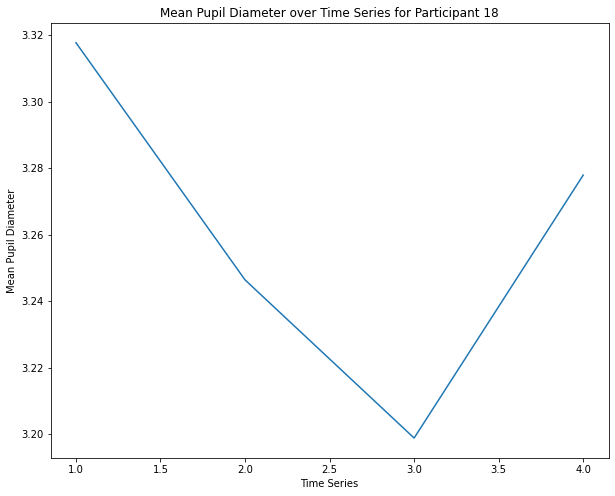

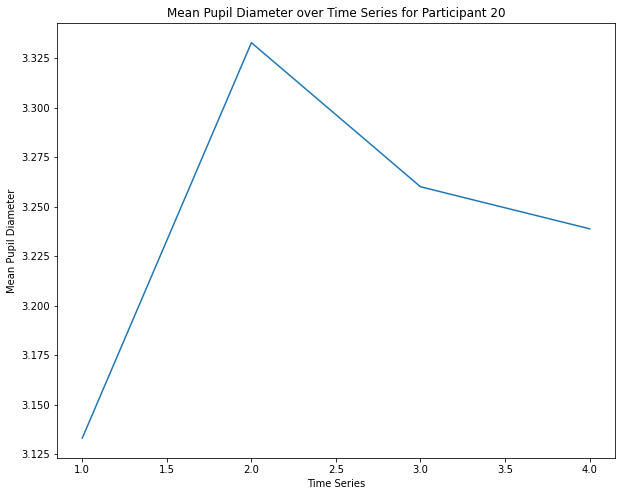

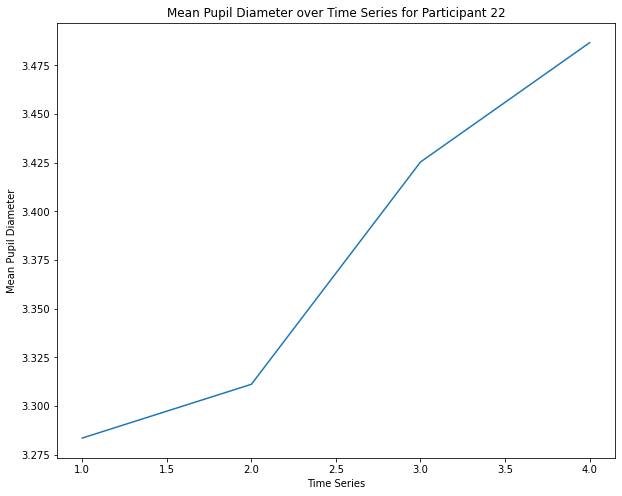

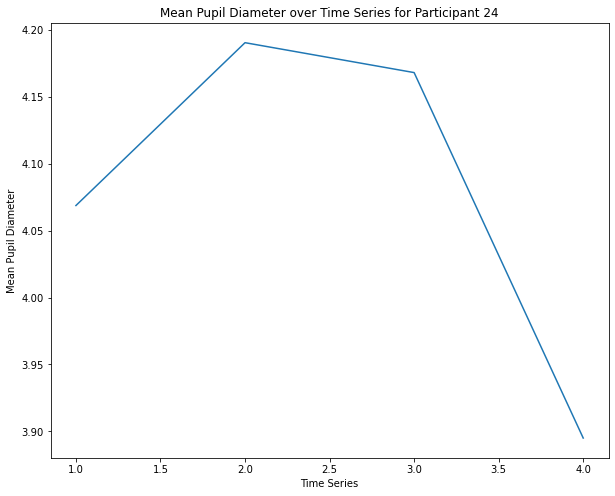

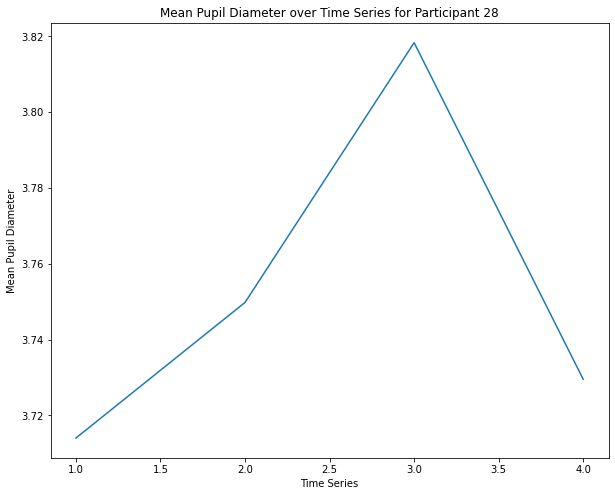

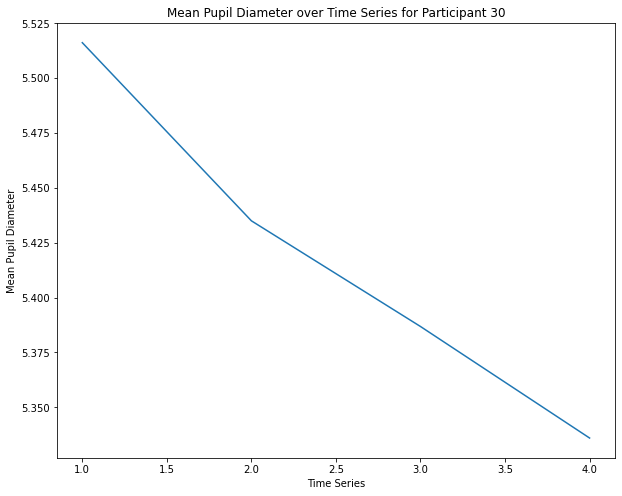

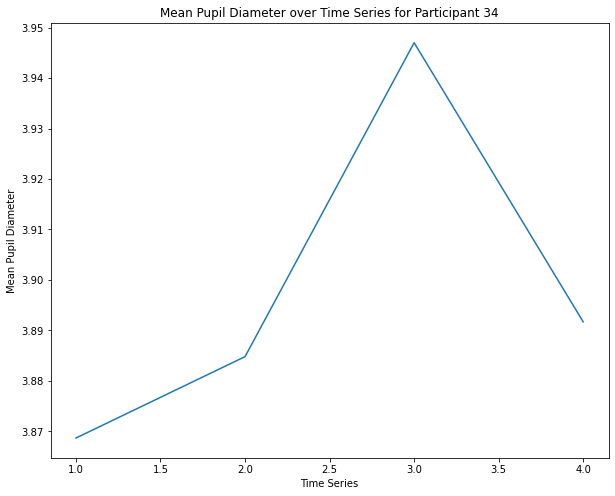

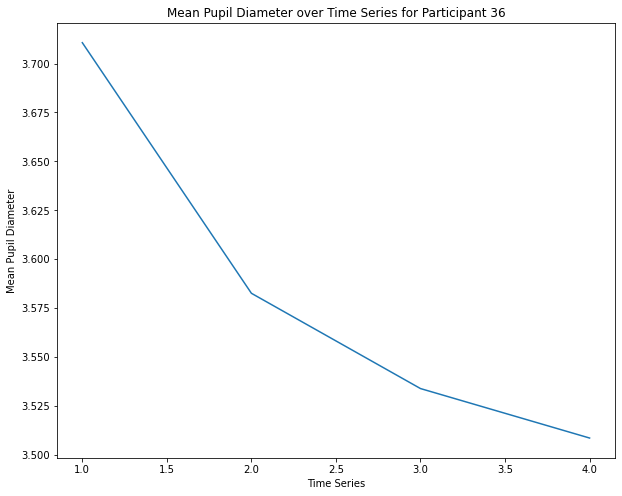

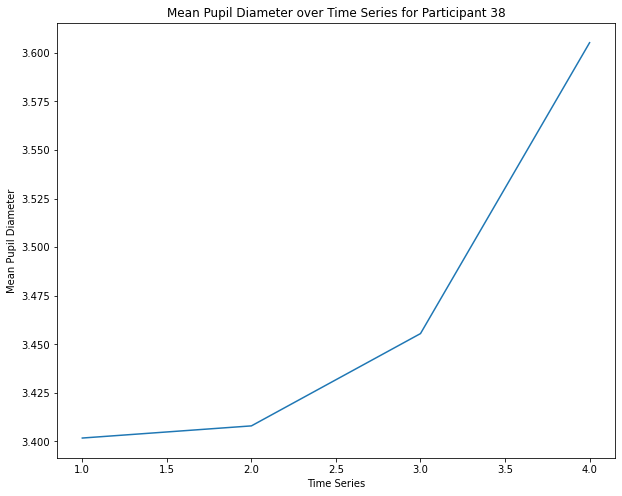

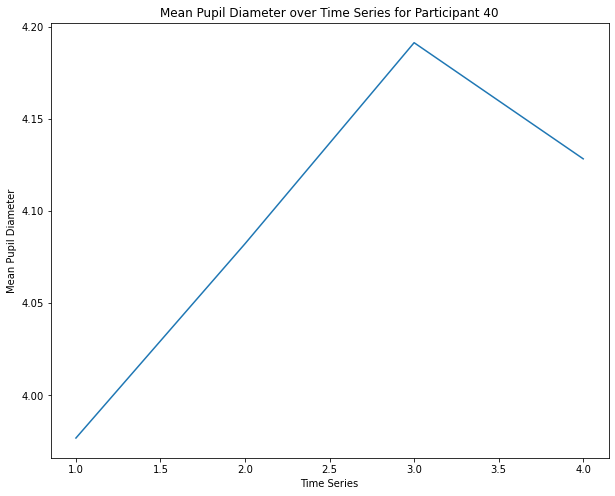

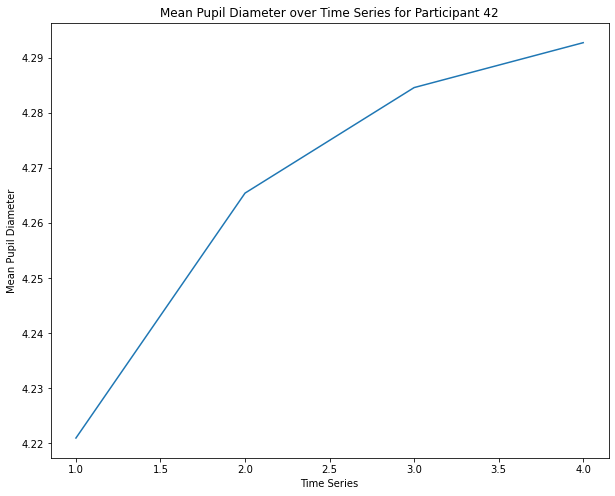

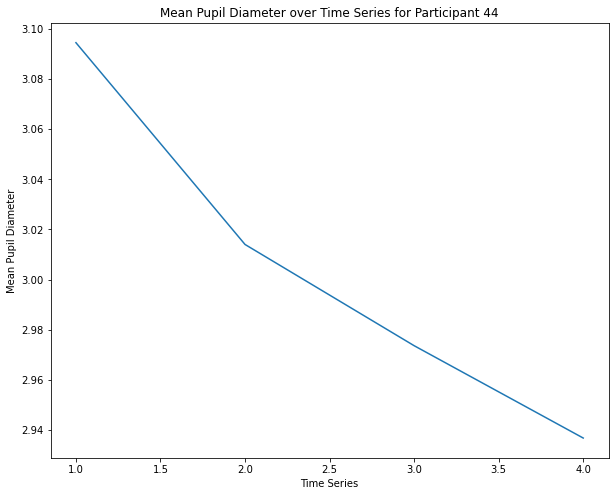

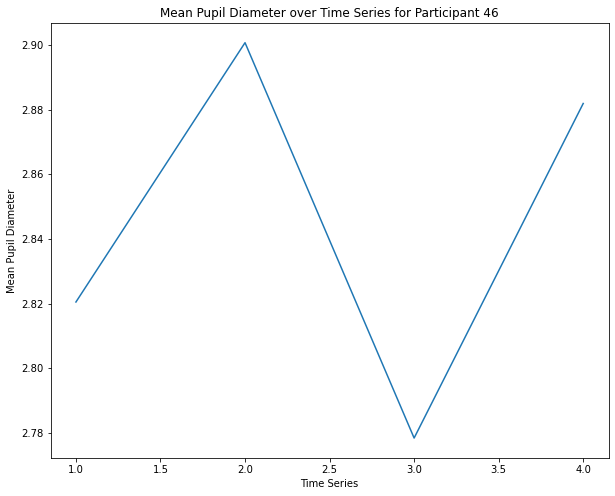

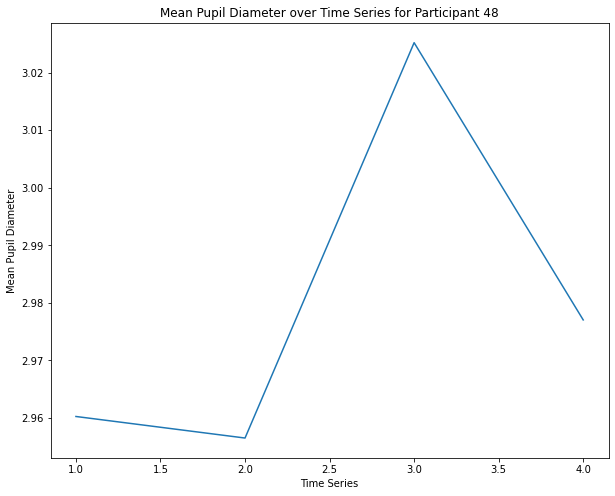

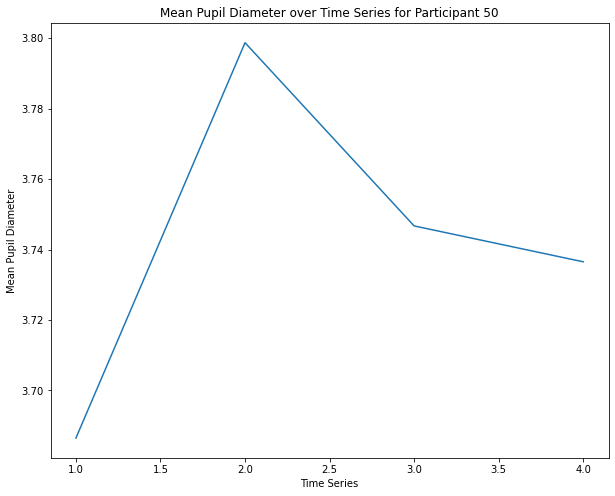

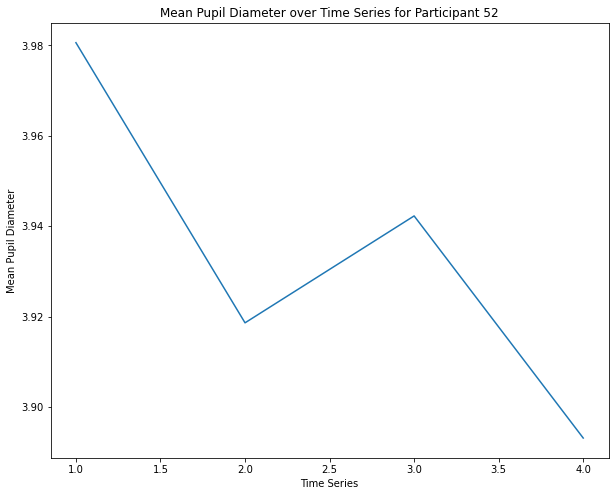

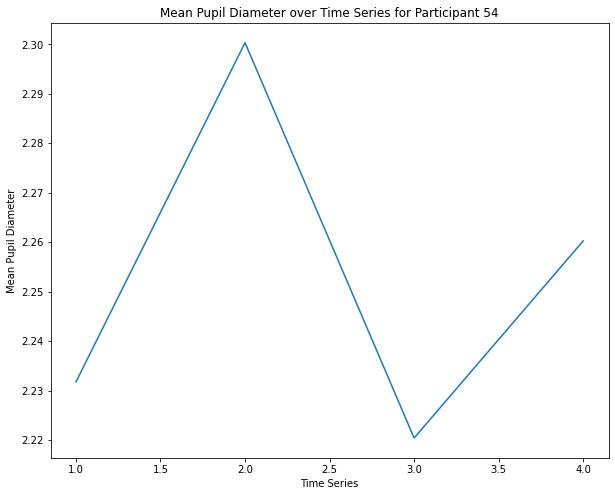

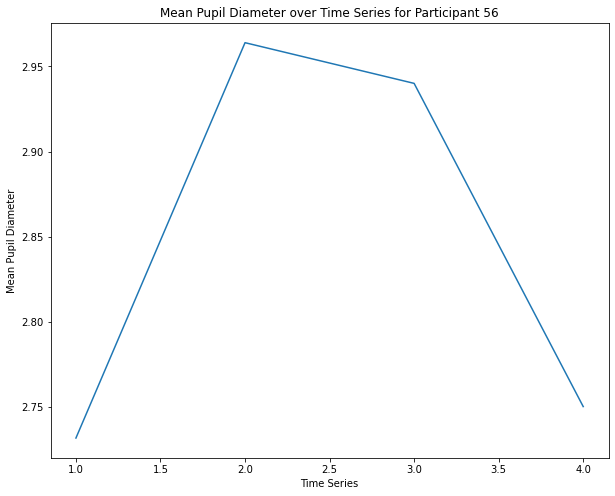

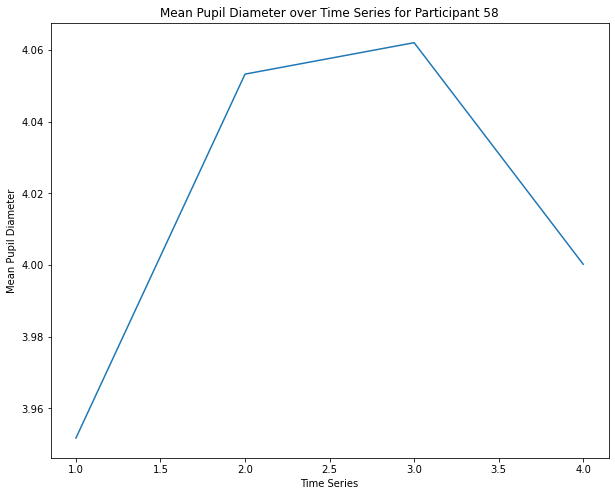

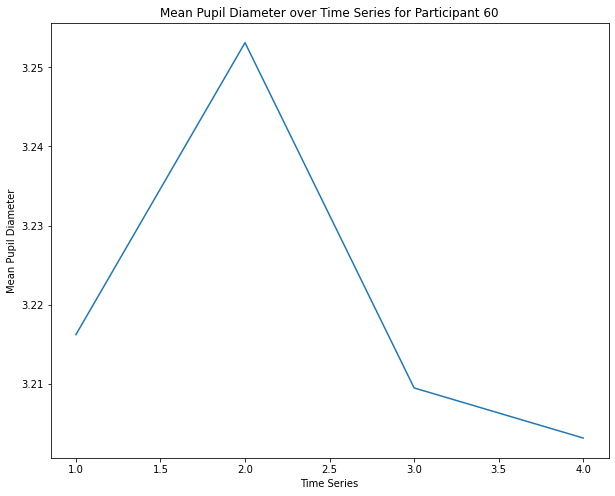

In [63]:
# Get a list of all participant names
participant_names = merged_data['Participant'].unique()


for participant_name in participant_names:
    fig, ax = plt.subplots(figsize=(10, 8))
    participant_data = merged_data[merged_data['Participant'] == participant_name]
    ax.plot(participant_data['Time Series'], participant_data['Mean Pupil Diameter'])
    ax.set_xlabel('Time Series')
    ax.set_ylabel('Mean Pupil Diameter')
    ax.set_title('Mean Pupil Diameter over Time Series for Participant {}'.format(participant_name))
    plt.show()

In [64]:
merged_data[['Fixation Count','Saccade Count']] = merged_data[['Fixation Count','Saccade Count']].astype(float)

In [66]:
merged_data.to_csv('Control_group.csv')

### Checking for the correlation between the features

In [68]:
# Calculating the correlation coefficients between the features
correlations2 = merged_data[['Mean Pupil Diameter', 'Total Score extended before', 
                            'Total Score extended after', 'Avg_Empathy_Score',
                            'Fixation Duration', 'Saccade Duration',
                            'Fixation Count', 'Saccade Count']].corr()

In [70]:
correlations2

,Mean Pupil Diameter,Total Score extended before,Total Score extended after,Avg_Empathy_Score,Fixation Duration,Saccade Duration,Fixation Count,Saccade Count
Mean Pupil Diameter,1.000000,0.022752,-0.198073,-0.162541,0.249672,0.250557,0.273101,-0.010067
Total Score extended before,0.022752,1.000000,-0.029973,0.478323,-0.034843,-0.010999,0.017786,0.005075
Total Score extended after,-0.198073,-0.029973,1.000000,0.863452,-0.209722,-0.124546,-0.223865,0.217217
Avg_Empathy_Score,-0.162541,0.478323,0.863452,1.000000,-0.201840,-0.114974,-0.187707,0.193403
Fixation Duration,0.249672,-0.034843,-0.209722,-0.201840,1.000000,0.925666,0.449150,0.201205
Saccade Duration,0.250557,-0.010999,-0.124546,-0.114974,0.925666,1.000000,0.391079,0.190025
Fixation Count,0.273101,0.017786,-0.223865,-0.187707,0.449150,0.391079,1.000000,0.642048
Saccade Count,-0.010067,0.005075,0.217217,0.193403,0.201205,0.190025,0.642048,1.000000


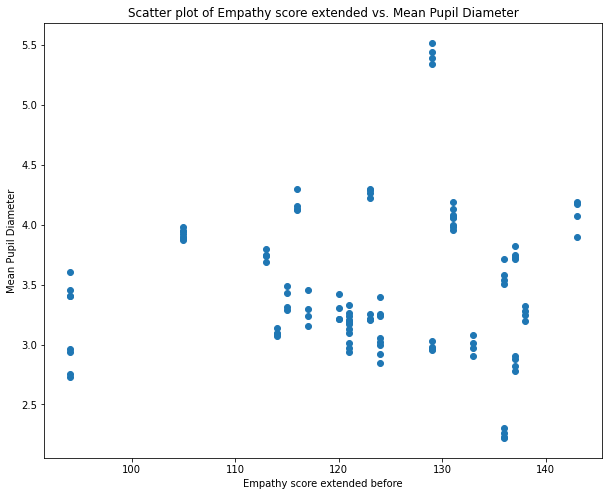

In [71]:
# Plotting Mean pupil diameter with extended empathy score before
plt.figure(figsize = (10,8))
plt.scatter(merged_data['Total Score extended before'], merged_data['Mean Pupil Diameter'])
plt.xlabel('Empathy score extended before')
plt.ylabel('Mean Pupil Diameter')
plt.title('Scatter plot of Empathy score extended vs. Mean Pupil Diameter')
plt.show()

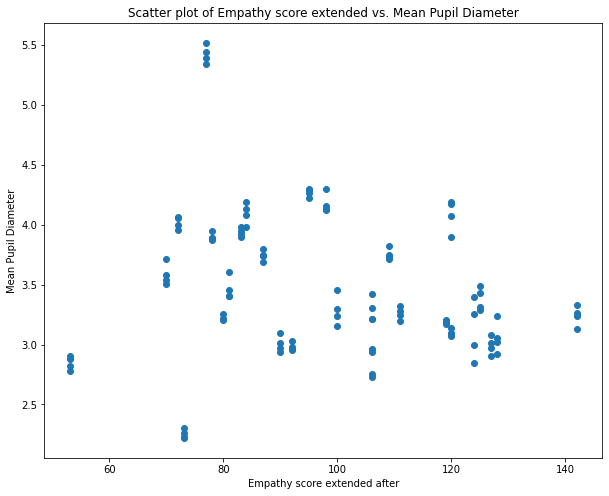

In [72]:
# Plotting Mean pupil diameter with extended empathy score after
plt.figure(figsize = (10,8))
plt.scatter(merged_data['Total Score extended after'], merged_data['Mean Pupil Diameter'])
plt.xlabel('Empathy score extended after')
plt.ylabel('Mean Pupil Diameter')
plt.title('Scatter plot of Empathy score extended vs. Mean Pupil Diameter')
plt.show()

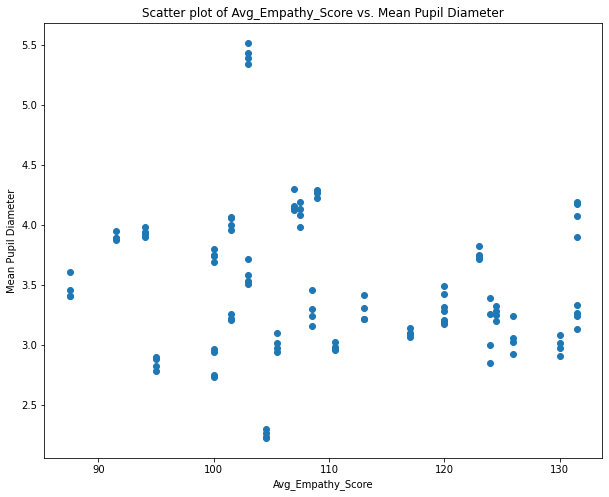

In [73]:
plt.figure(figsize = (10,8))
plt.scatter(merged_data['Avg_Empathy_Score'], merged_data['Mean Pupil Diameter'])
plt.xlabel('Avg_Empathy_Score')
plt.ylabel('Mean Pupil Diameter')
plt.title('Scatter plot of Avg_Empathy_Score vs. Mean Pupil Diameter')
plt.show()

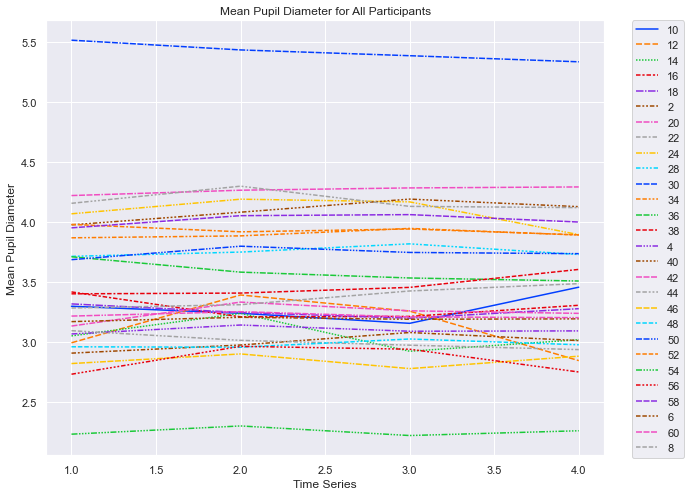

In [74]:
#Plotting mean pupil diameter vs time series for all participants 
plt.figure(figsize =(10,8))
pivoted_data = merged_data.pivot(index='Participant', columns='Time Series', values='Mean Pupil Diameter')

# Create a line plot of the mean pupil diameter for each participant
sns.set(style="darkgrid")
sns.lineplot(data=pivoted_data.T, palette='bright')

# Add axis labels and a title
plt.xlabel('Time Series')
plt.ylabel('Mean Pupil Diameter')
plt.title('Mean Pupil Diameter for All Participants')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

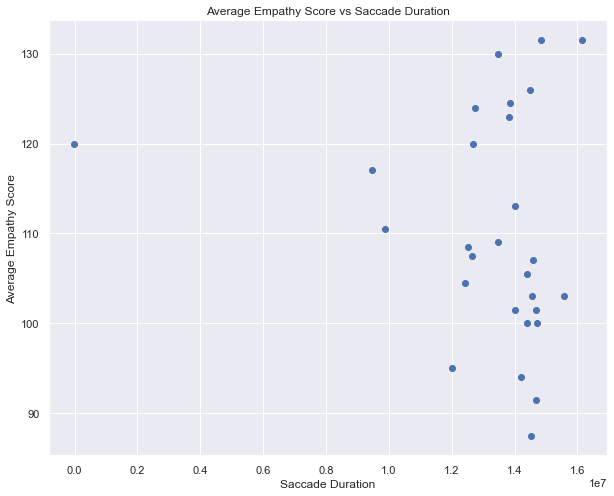

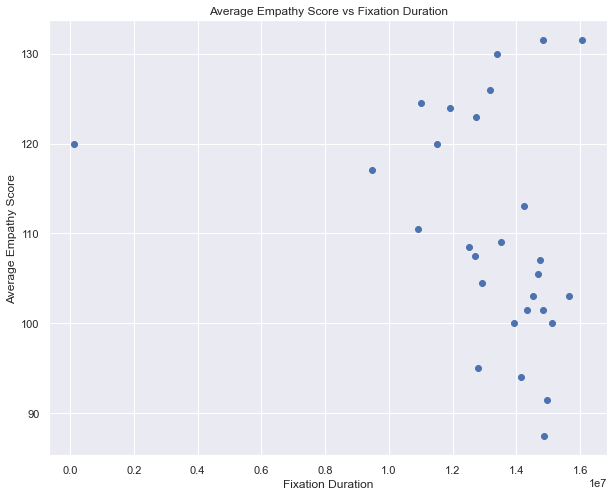

In [75]:
import matplotlib.pyplot as plt

grouped_data = merged_data.groupby('Participant').agg({'Avg_Empathy_Score': 'mean', 'Fixation Duration': 'mean', 'Saccade Duration': 'mean'})

# Creating a scatter plot of Saccade Duration and Avg_Empathy_Score
plt.figure(figsize = (10,8))
plt.scatter(grouped_data['Saccade Duration'], grouped_data['Avg_Empathy_Score'])
plt.xlabel('Saccade Duration')
plt.ylabel('Average Empathy Score')
plt.title('Average Empathy Score vs Saccade Duration')
plt.show()

# Creating a scatter plot of Fixation Duration and Avg_Empathy_Score
plt.figure(figsize = (10,8))
plt.scatter(grouped_data['Fixation Duration'], grouped_data['Avg_Empathy_Score'])
plt.xlabel('Fixation Duration')
plt.ylabel('Average Empathy Score')
plt.title('Average Empathy Score vs Fixation Duration')
plt.show()

In [76]:
ml = merged_data[['Participant','Mean Pupil Diameter','Fixation Count','Saccade Count',
                  'Avg_Empathy_Score']]

In [77]:
ml

,Participant,Mean Pupil Diameter,Fixation Count,Saccade Count,Avg_Empathy_Score
0,2,2.907293,8608.0,2664.0,130.0
1,2,2.974948,8892.0,2908.0,130.0
2,2,3.079200,5192.0,3612.0,130.0
3,2,3.011930,8812.0,3168.0,130.0
4,4,3.067076,6360.0,4725.0,117.0
...,...,...,...,...,...
107,58,4.000215,5149.0,816.0,101.5
108,60,3.216202,5020.0,1014.0,101.5
109,60,3.253124,5012.0,893.0,101.5
110,60,3.209456,5336.0,936.0,101.5


### Implementing Machine learning pipeline to predict the empathy score

In [79]:
# Splitting the data into features varibale X and target variable y
X = ml[['Mean Pupil Diameter','Fixation Count','Saccade Count']]
y = ml['Avg_Empathy_Score']

# Initialize the linear regression and random forest regression models
lr = LinearRegression()
rf = RandomForestRegressor()

# Initializing the pipeline for the linear regression model
lr_pipeline = Pipeline(steps=[('linear_reg', lr)])

# Initializing  the pipeline for the random forest regression model
rf_pipeline = Pipeline(steps=[('random_forest', rf)])

# Initialize a list to store the RMSE for each fold
rmse_list_lr = []
rmse_list_rf = []

# Initialize a list to store the RMSE for each fold
r2_list_lr = []
r2_list_rf = []


# Perform 10-fold cross-validation for linear regression
g = GroupKFold(n_splits=10)
for train_idx, test_idx in g.split(X, y, groups=ml['Participant']):
    # Split the data into training and testing sets for each fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Fit the linear regression model to the training data
    lr_pipeline.fit(X_train, y_train)
    
    # Make predictions for the test data
    y_pred = lr_pipeline.predict(X_test)
    
    
    #Calculate the r2 for the model prediction
    r2 = r2_score(y_test, y_pred)
    r2_list_lr.append(r2)
    
    # Calculate the RMSE for the model predictions
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Add the RMSE to the list
    rmse_list_lr.append(rmse)

# Perform 10-fold cross-validation for random forest regression
for train_idx, test_idx in g.split(X, y, groups=ml['Participant']):
    # Split the data into training and testing sets for each fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Fit the random forest regression model to the training data
    rf_pipeline.fit(X_train, y_train)
    
    # Make predictions for the test data
    y_pred = rf_pipeline.predict(X_test)
    
    #Calculate the r2 for the model prediction
    r2 = r2_score(y_test, y_pred)
    r2_list_rf.append(r2)
    
    
    # Calculate the RMSE for the model's predictions
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Add the RMSE to the list
    rmse_list_rf.append(rmse)

# Calculating the mean RMSE across all folds for linear regression
mean_rmse_lr = np.mean(rmse_list_lr)
print('Mean RMSE for Linear Regression:', mean_rmse_lr)

# Calculating the r2 scores across all folds for linear regression
mean_r2_lr = np.mean(r2_list_lr)
print('Mean r2 for Linear Regression:', mean_r2_lr)
#####################################################################################3

# Calculating the mean RMSE across all folds for random forest regression
mean_rmse_rf = np.mean(rmse_list_rf)
print('Mean RMSE for Random Forest Regression:', mean_rmse_rf)

# Calculating the  mean r2 scores across all folds for random forest regression
mean_r2_rf = np.mean(r2_list_rf)
print('Mean r2 for Linear Regression:', mean_r2_rf)

Mean RMSE for Linear Regression: 12.379265658966663
Mean r2 for Linear Regression: -3.0236364646276512
Mean RMSE for Random Forest Regression: 12.450851140195317
Mean r2 for Linear Regression: -4.318553795651999


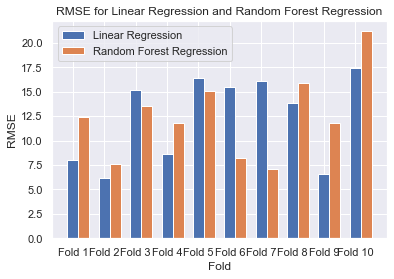

In [80]:
x_labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5','Fold 6','Fold 7','Fold 8','Fold 9','Fold 10']


bar_width = 0.35

fig, ax = plt.subplots()


ax.bar(x_labels, rmse_list_lr, bar_width, label='Linear Regression')
ax.bar([i + bar_width for i in range(len(rmse_list_rf))], rmse_list_rf, bar_width, label='Random Forest Regression')

ax.set_title('RMSE for Linear Regression and Random Forest Regression')
ax.set_xlabel('Fold')
ax.set_ylabel('RMSE')

ax.legend()

plt.show()